# Explore here

In [1]:
# Your code here
import pandas as pd

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

print(total_data.head())

                         date      sales
0  2022-09-03 17:10:08.079328  55.292157
1  2022-09-04 17:10:08.079328  53.803211
2  2022-09-05 17:10:08.079328  58.141693
3  2022-09-06 17:10:08.079328  64.530899
4  2022-09-07 17:10:08.079328  66.013633


#### Time index formating

In [2]:
total_data['date'] = pd.to_datetime(total_data['date'])

#### Visualising Data

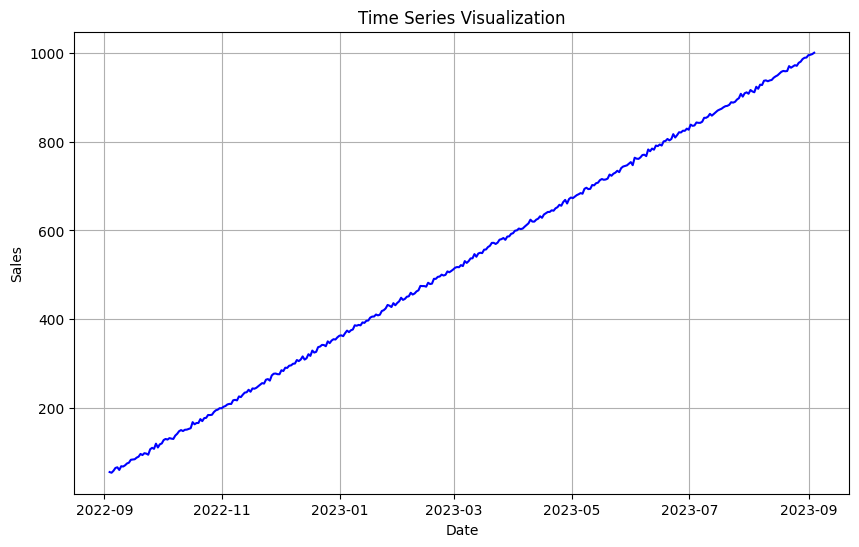

In [3]:
import matplotlib.pyplot as plt


# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(total_data['date'], total_data['sales'], color='blue')
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


### Split Data

In [4]:
from datetime import datetime

# Sort the DataFrame by timestamp
total_data.sort_values(by='date', inplace=True)

# Determine the split point for training and testing data
split_ratio = 0.8  # 80% training data, 20% testing data
split_index = int(len(total_data) * split_ratio)

# Split the dataset into training and testing sets
train_data = total_data[:split_index]
test_data = total_data[split_index:]

# Reset the index for both training and testing data
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Display the shapes of the training and testing sets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (292, 2)
Testing data shape: (74, 2)


### Perform Dicky Fuller Test

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

# Test stationarity using only the 'sales' column
result = test_stationarity(total_data['sales'])
print(result)

Dickey-Fuller test results:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


#### Difference data and try again

In [6]:
# Perform differencing on the 'sales' column
total_data['sales_diff'] = total_data['sales'].diff()

# Drop the first row since differencing introduces NaN values
total_data.dropna(inplace=True)

# Test stationarity of the differenced data
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

result = test_stationarity(total_data['sales_diff'])
print(result)

Dickey-Fuller test results:
Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64


### Search for Seasonality
- decompose on differentiated data
- ACF graphing

#### Decompose

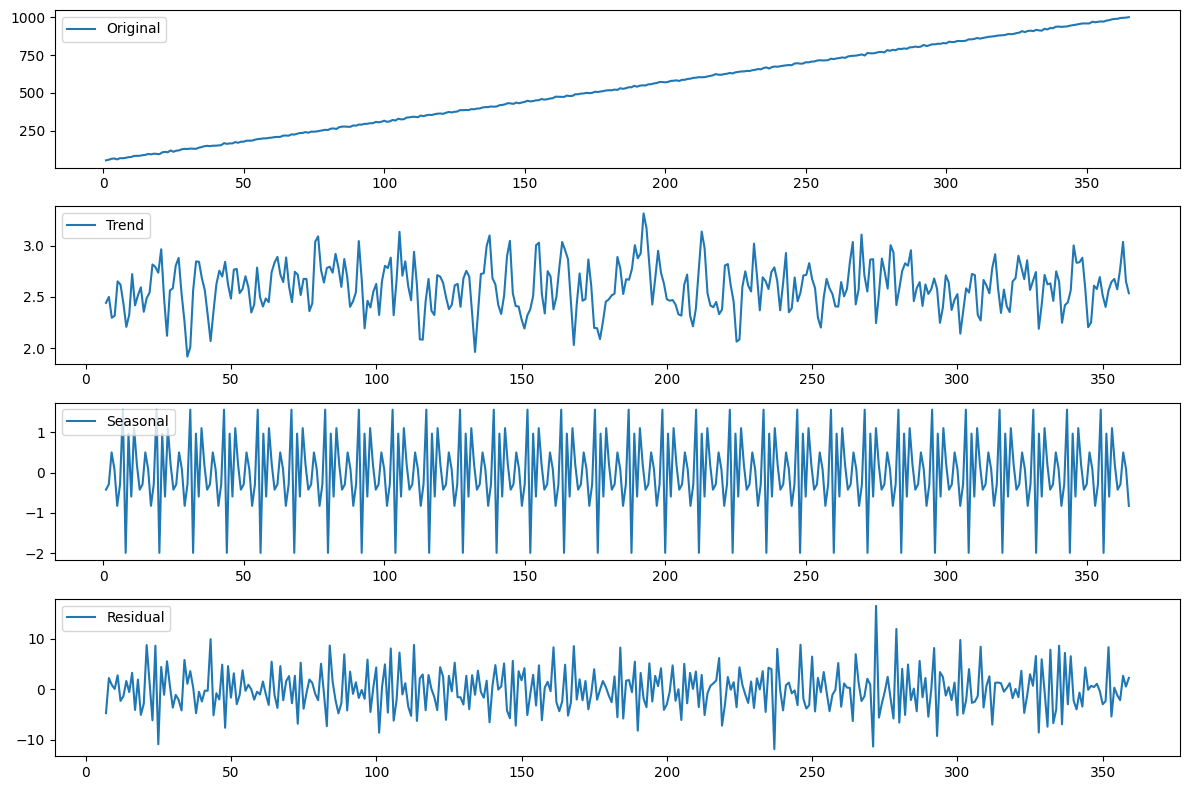

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(total_data['sales_diff'], model='additive', period=12)  # Assuming monthly seasonality

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(total_data['sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

NOTE: we can see that the pattern repeats around the 12 day mark (we shall urther explore this with an ACF graph of the seasoal decompose graph)

#### ACF of total differentiated data

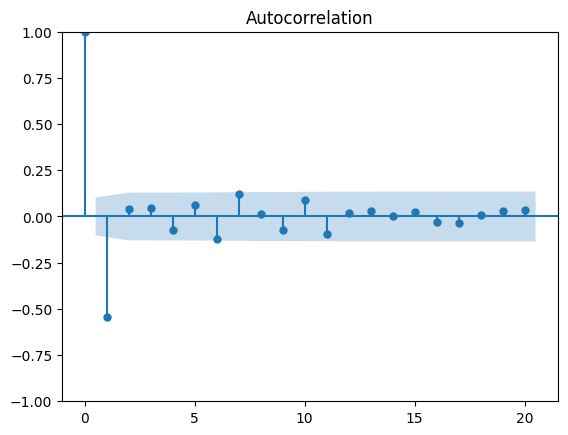

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function
plot_acf(total_data['sales_diff'], lags=20)  # Adjust lags as needed
plt.show()

### ACF of decomposed seasonal graph for further inspection to determine 'm' value

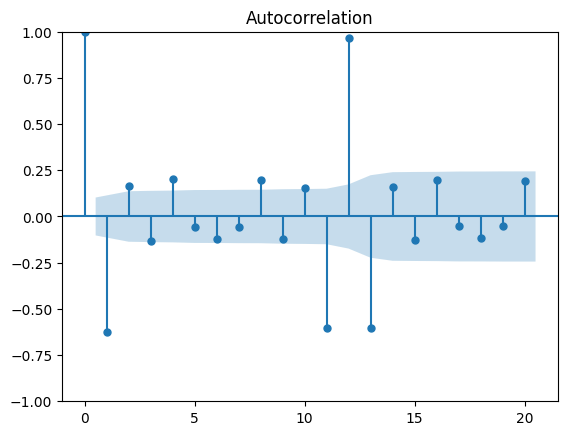

In [9]:
seasonal_data = decomposition.seasonal
# Plot the autocorrelation function
plot_acf(seasonal_data, lags=20)  # Adjust lags as needed
plt.show()

#### m = 12

In [10]:
train_data['sales_diff'] = train_data['sales'].diff()
train_data.dropna(inplace=True)
test_data['sales_diff'] = test_data['sales'].diff()
test_data.dropna(inplace=True)

/tmp/ipykernel_717/2221130917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sales_diff'] = train_data['sales'].diff()
/tmp/ipykernel_717/2221130917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(inplace=True)
/tmp/ipykernel_717/2221130917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

### Model training

In [11]:
from pmdarima import auto_arima

model = auto_arima(train_data['sales'], seasonal = True, trace = True, d = 1, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1477.455, Time=3.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1669.776, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1574.694, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1471.109, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1758.617, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1469.175, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1471.105, Time=0.47 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1472.960, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1469.743, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1469.725, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1573.404, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1473.090, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1757.827, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 5.568 seconds


In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  291
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -731.587
Date:                Tue, 09 Apr 2024   AIC                           1469.175
Time:                        04:13:24   BIC                           1480.184
Sample:                             0   HQIC                          1473.586
                                - 291                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5994      0.010    268.884      0.000       2.580       2.618
ma.L1         -0.9496      0.021    -45.925      0.000      -0.990      -0.909
sigma2         9.0209      0.820     11.004      0.000       7.414      10.628
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.26   Prob(JB):                         0.51
Heteroskedasticity (H):               0.96   Skew:                             0.05
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Model prediction

In [15]:
forecast = model.predict(73)  #  = size of test data 

forecast

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


291    810.065041
292    812.664460
293    815.263879
294    817.863298
295    820.462717
          ...    
359    986.825528
360    989.424947
361    992.024366
362    994.623784
363    997.223203
Length: 73, dtype: float64

### Plot of real Test Values Against Prediction

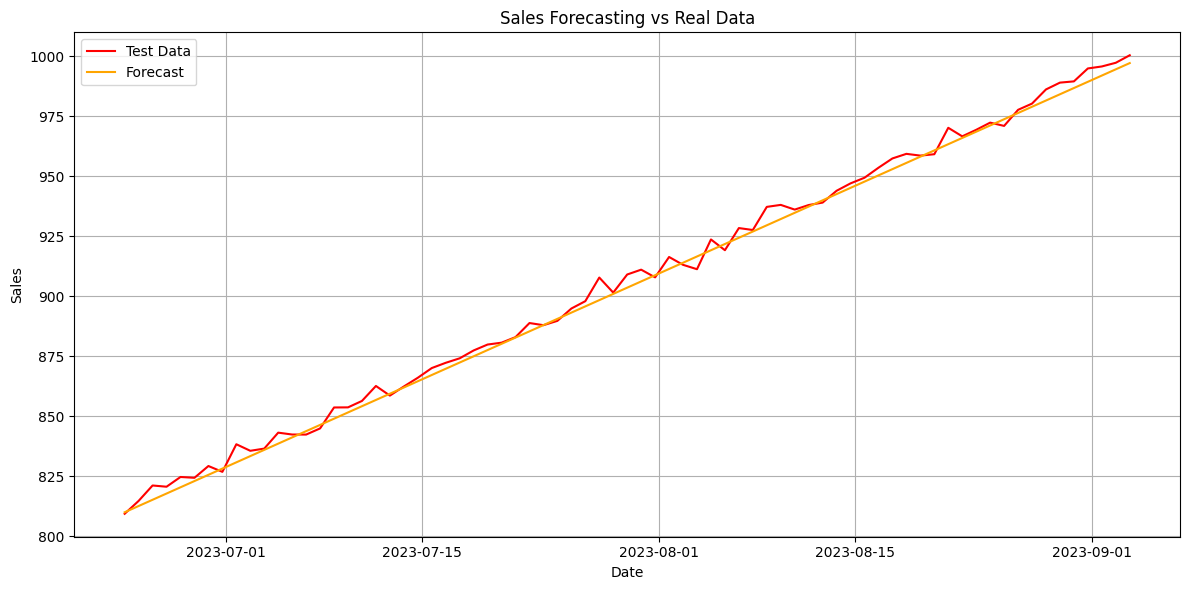

In [16]:
import matplotlib.pyplot as plt

# Plotting the time series data
plt.figure(figsize=(12, 6))

# Plotting the test data
plt.plot(test_data['date'], test_data['sales'], label='Test Data', color='red')

# Plotting the forecast
plt.plot(test_data['date'], forecast, label='Forecast', color='orange')

# Adding labels and title
plt.title('Sales Forecasting vs Real Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Our model is now able to make forward predictions on our stationary series.